# DenseNet-121

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torchvision.models import densenet121

from PIL import Image
import matplotlib.pyplot as plt

if torch.cuda.is_available():
    device = torch.device("cuda")  # GPU
    print(f"GPU mavjud: {torch.cuda.get_device_name(device)}")
else:
    device = torch.device("cpu")  # CPU
    print("GPU mavjud emas, CPU ishlatiladi.")
    
torch.cuda.empty_cache()   # Xotiradan bo‘shatish

GPU mavjud: NVIDIA GeForce RTX 3060


In [16]:
# Hyperparameters
BATCH_SIZE = 32
LR = 0.00001
EPOCHS = 15
NUM_CLASSES = 7  # FER-2013 yoki FaceEmocDS uchun


In [17]:
# Data Augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Dataset yuklash (train va val uchun)
train_dataset = datasets.ImageFolder("fer_2013_new/train", transform=transform)
val_dataset = datasets.ImageFolder("fer_2013_new/test", transform=transform_val)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [18]:
# Model yaratish
model = densenet121(weights="IMAGENET1K_V1")
model.classifier = nn.Linear(model.classifier.in_features, NUM_CLASSES)  # 7 sinf uchun chiqish
model = model.to(device)

# Loss va optimizer
target_loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

In [19]:
# Train function
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

def train(model, train_loader, val_loader, epochs):
    best_val_acc = 0.0  # Eng yaxshi validation accuracy ni saqlash uchun
    for epoch in range(epochs):
        model.train()
        train_loss, train_correct, total = 0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = target_loss(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * images.size(0)
            _, preds = outputs.max(1)
            train_correct += (preds == labels).sum().item()
            total += labels.size(0)
        
        train_losses.append(train_loss / total)
        train_accuracies.append(100 * train_correct / total)
        
        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = target_loss(outputs, labels)
                val_loss += loss.item() * images.size(0)
                _, preds = outputs.max(1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)
        
        val_losses.append(val_loss / val_total)
        val_accuracies.append(100 * val_correct / val_total)
        
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss/total:.4f}, Train Accuracy: {100*train_correct/total:.2f}%",
              f"Val Loss: {val_loss/val_total:.4f}, Val Accuracy: {100*val_correct/val_total:.2f}%")
        torch.save(model.state_dict(), f"densenet_fer2013_epoch{epoch+1}.pth")
        if val_accuracies[-1] > best_val_acc:
            best_val_acc = val_accuracies[-1]
            torch.save(model.state_dict(), 'densenet_fer2013_best_model.pth')
            print(f"New best model saved with Val Accuracy: {best_val_acc:.2f}%")


In [20]:
# Train model 
train(model, train_loader, val_loader, EPOCHS)

Epoch 1/15, Train Loss: 1.4405, Train Accuracy: 47.01% Val Loss: 1.1458, Val Accuracy: 57.25%
New best model saved with Val Accuracy: 57.25%
Epoch 2/15, Train Loss: 1.0881, Train Accuracy: 59.85% Val Loss: 1.0046, Val Accuracy: 62.61%
New best model saved with Val Accuracy: 62.61%
Epoch 3/15, Train Loss: 0.9728, Train Accuracy: 63.89% Val Loss: 0.9313, Val Accuracy: 65.32%
New best model saved with Val Accuracy: 65.32%
Epoch 4/15, Train Loss: 0.8984, Train Accuracy: 66.73% Val Loss: 0.8842, Val Accuracy: 66.91%
New best model saved with Val Accuracy: 66.91%
Epoch 5/15, Train Loss: 0.8497, Train Accuracy: 68.72% Val Loss: 0.8601, Val Accuracy: 67.95%
New best model saved with Val Accuracy: 67.95%
Epoch 6/15, Train Loss: 0.8111, Train Accuracy: 70.32% Val Loss: 0.8438, Val Accuracy: 68.83%
New best model saved with Val Accuracy: 68.83%
Epoch 7/15, Train Loss: 0.7752, Train Accuracy: 71.48% Val Loss: 0.8305, Val Accuracy: 69.32%
New best model saved with Val Accuracy: 69.32%
Epoch 8/15, T

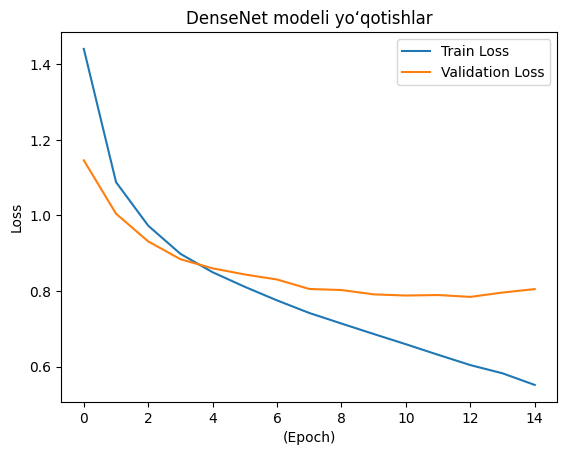

In [21]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('(Epoch)')
plt.ylabel('Loss')
plt.legend()
plt.title('DenseNet modeli yo‘qotishlar')
plt.show()

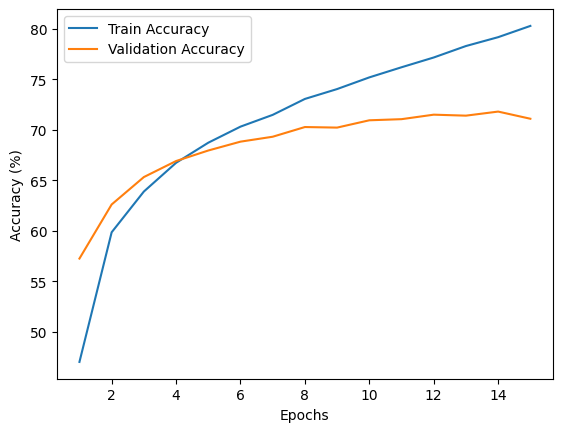

In [22]:
plt.plot(range(1, EPOCHS+1), train_accuracies, label="Train Accuracy")
plt.plot(range(1, EPOCHS+1), val_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.show()

In [21]:
# Train model yangisi
train(model, train_loader, val_loader, EPOCHS)

Epoch 1/15, Train Loss: 0.5751, Train Accuracy: 79.30% Val Loss: 0.8018, Val Accuracy: 71.45%
Epoch 2/15, Train Loss: 0.5544, Train Accuracy: 80.18% Val Loss: 0.8003, Val Accuracy: 71.31%
Epoch 3/15, Train Loss: 0.5329, Train Accuracy: 80.81% Val Loss: 0.8024, Val Accuracy: 72.20%
Epoch 4/15, Train Loss: 0.5045, Train Accuracy: 82.05% Val Loss: 0.8173, Val Accuracy: 71.74%
Epoch 5/15, Train Loss: 0.4794, Train Accuracy: 82.91% Val Loss: 0.8255, Val Accuracy: 71.43%
Epoch 6/15, Train Loss: 0.4614, Train Accuracy: 83.41% Val Loss: 0.8379, Val Accuracy: 71.60%
Epoch 7/15, Train Loss: 0.4404, Train Accuracy: 84.22% Val Loss: 0.8460, Val Accuracy: 71.75%
Epoch 8/15, Train Loss: 0.4223, Train Accuracy: 85.11% Val Loss: 0.8525, Val Accuracy: 71.74%
Epoch 9/15, Train Loss: 0.4040, Train Accuracy: 85.94% Val Loss: 0.8678, Val Accuracy: 71.79%
Epoch 10/15, Train Loss: 0.3807, Train Accuracy: 86.48% Val Loss: 0.8824, Val Accuracy: 71.31%
Epoch 11/15, Train Loss: 0.3633, Train Accuracy: 87.22% Val

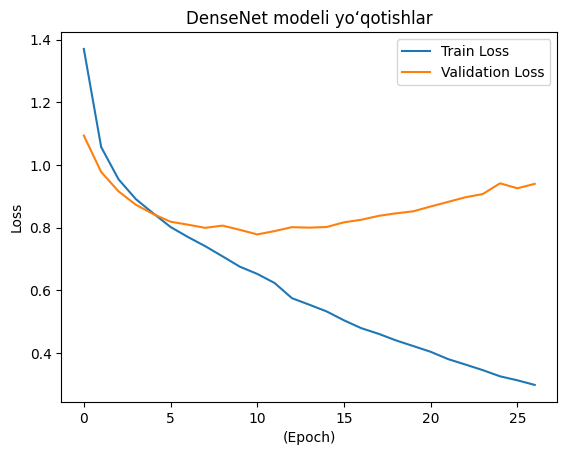

In [22]:
from PIL import Image
import matplotlib.pyplot as plt
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('(Epoch)')
plt.ylabel('Loss')
plt.legend()
plt.title('DenseNet modeli yo‘qotishlar')
plt.show()

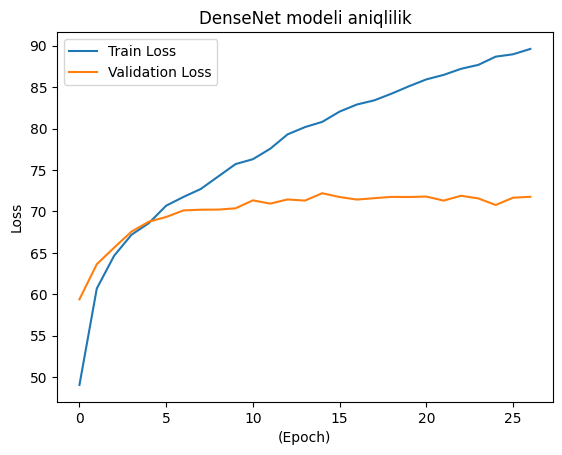

In [23]:
plt.plot(train_accuracies, label='Train Loss')
plt.plot(val_accuracies, label='Validation Loss')
plt.xlabel('(Epoch)')
plt.ylabel('Loss')
plt.legend()
plt.title('DenseNet modeli aniqlilik')
plt.show()

In [18]:
# Train model
train(model, train_loader, val_loader, EPOCHS)


Epoch 1/15, Train Loss: 1.3708, Train Accuracy: 49.05% Val Loss: 1.0942, Val Accuracy: 59.39%
Epoch 2/15, Train Loss: 1.0576, Train Accuracy: 60.69% Val Loss: 0.9781, Val Accuracy: 63.62%
Epoch 3/15, Train Loss: 0.9548, Train Accuracy: 64.65% Val Loss: 0.9162, Val Accuracy: 65.63%
Epoch 4/15, Train Loss: 0.8914, Train Accuracy: 67.18% Val Loss: 0.8733, Val Accuracy: 67.56%
Epoch 5/15, Train Loss: 0.8461, Train Accuracy: 68.59% Val Loss: 0.8438, Val Accuracy: 68.76%
Epoch 6/15, Train Loss: 0.8025, Train Accuracy: 70.69% Val Loss: 0.8193, Val Accuracy: 69.33%
Epoch 7/15, Train Loss: 0.7705, Train Accuracy: 71.75% Val Loss: 0.8098, Val Accuracy: 70.12%
Epoch 8/15, Train Loss: 0.7411, Train Accuracy: 72.72% Val Loss: 0.7997, Val Accuracy: 70.21%
Epoch 9/15, Train Loss: 0.7086, Train Accuracy: 74.22% Val Loss: 0.8068, Val Accuracy: 70.22%
Epoch 10/15, Train Loss: 0.6756, Train Accuracy: 75.71% Val Loss: 0.7933, Val Accuracy: 70.37%
Epoch 11/15, Train Loss: 0.6526, Train Accuracy: 76.31% Val

KeyboardInterrupt: 

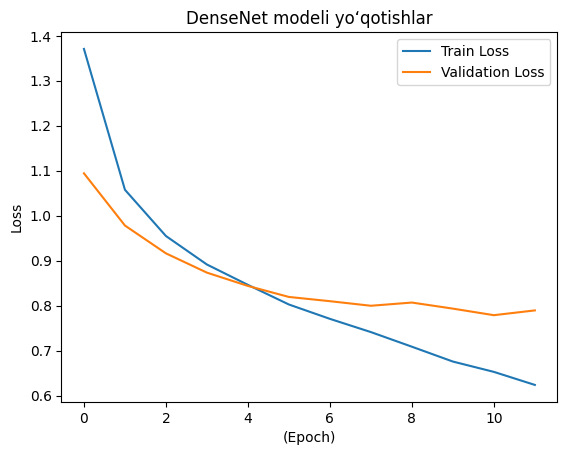

In [19]:
from PIL import Image
import matplotlib.pyplot as plt
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('(Epoch)')
plt.ylabel('Loss')
plt.legend()
plt.title('DenseNet modeli yo‘qotishlar')
plt.show()

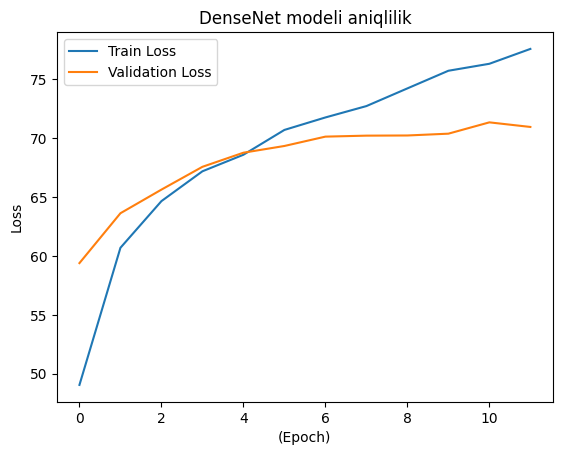

In [20]:
plt.plot(train_accuracies, label='Train Loss')
plt.plot(val_accuracies, label='Validation Loss')
plt.xlabel('(Epoch)')
plt.ylabel('Loss')
plt.legend()
plt.title('DenseNet modeli aniqlilik')
plt.show()

In [11]:
print(train_accuracies)
print(train_losses)
print(val_accuracies)
print(val_losses)

[46.745376658656355, 60.39772925155853, 64.2670567338836, 67.17514714589211, 69.19862083376867, 70.95392330999896, 72.45498554661651, 73.73663497370529, 74.96604325566817, 76.21286525267301, 77.35520495942605, 78.63337164350642, 79.9150210705952, 80.88322362692857, 82.07083899279073, 83.17835126945982, 84.12914011075122, 85.07644620903423, 86.37202660815659, 86.92230000348275]
[1.4265859665070375, 1.0768138410545784, 0.9611705553401697, 0.889724272545804, 0.8373358718895453, 0.7941992103138036, 0.754826551619125, 0.7218319713203726, 0.6893601857461272, 0.6561180977505319, 0.6271784571077127, 0.5962047825033827, 0.5613884097899663, 0.5369060744031263, 0.5078064944142687, 0.47546009956592594, 0.4496309110669761, 0.42386385886782835, 0.39291095886219507, 0.3745094820718483]
[58.123346791034386, 63.06557148823611, 65.1956007239315, 67.10288180426006, 67.77112627036057, 68.84310176806348, 70.17959070026451, 69.21898928024503, 70.17959070026451, 70.15174718084366, 70.56939997215648, 70.23527

In [ ]:
train_accuracies1 = [46.745376658656355, 60.39772925155853, 64.2670567338836, 67.17514714589211, 69.19862083376867, 70.95392330999896, 72.45498554661651, 73.73663497370529, 74.96604325566817, 76.21286525267301, 77.35520495942605, 78.63337164350642, 79.9150210705952, 80.88322362692857, 82.07083899279073, 83.17835126945982, 84.12914011075122, 85.07644620903423, 86.37202660815659, 86.92230000348275]
train_losses1 = [1.4265859665070375, 1.0768138410545784, 0.9611705553401697, 0.889724272545804, 0.8373358718895453, 0.7941992103138036, 0.754826551619125, 0.7218319713203726, 0.6893601857461272, 0.6561180977505319, 0.6271784571077127, 0.5962047825033827, 0.5613884097899663, 0.5369060744031263, 0.5078064944142687, 0.47546009956592594, 0.4496309110669761, 0.42386385886782835, 0.39291095886219507, 0.3745094820718483]
val_accuracies1 = [58.123346791034386, 63.06557148823611, 65.1956007239315, 67.10288180426006, 67.77112627036057, 68.84310176806348, 70.17959070026451, 69.21898928024503, 70.17959070026451, 70.15174718084366, 70.56939997215648, 70.23527773910622, 71.01489628289016, 70.75038284839204, 70.90352220520674, 71.08450508144229, 71.25156619796742, 70.86175692607546, 71.12627036057357, 70.66685229012947]
val_losses1 = [1.1467530849118361, 0.9967692436513738, 0.936244984319843, 0.8874910085351956, 0.8539794820747086, 0.8388590751215557, 0.818392911686566, 0.8199482864881648, 0.8056729716103206, 0.8026688452714104, 0.7956540941212912, 0.803615725950728, 0.8032127893080573, 0.8106920348536615, 0.8292806843902745, 0.8269780941279539, 0.8503151508002798, 0.8721000185986009, 0.8699167061726246, 0.8827452600815494]


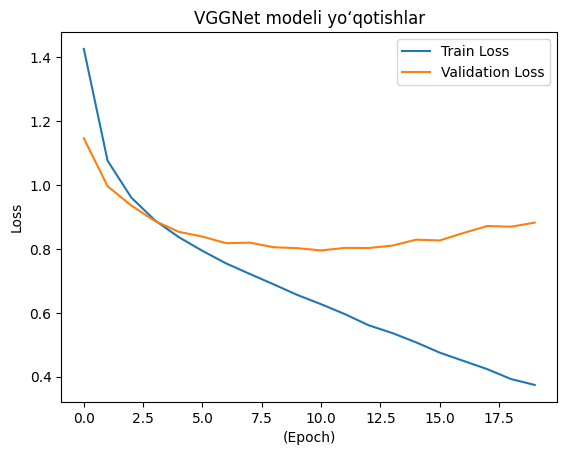

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
plt.plot(train_losses1, label='Train Loss')
plt.plot(val_losses1, label='Validation Loss')
plt.xlabel('(Epoch)')
plt.ylabel('Loss')
plt.legend()
plt.title('DenseNet modeli yo‘qotishlar')
plt.show()

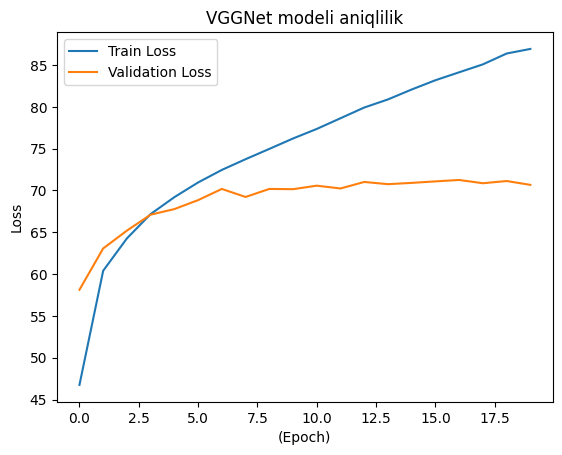

In [10]:
plt.plot(train_accuracies1, label='Train Loss')
plt.plot(val_accuracies1, label='Validation Loss')
plt.xlabel('(Epoch)')
plt.ylabel('Loss')
plt.legend()
plt.title('DenseNet modeli aniqlilik')
plt.show()

In [ ]:
# Save metrics for visualization
torch.save({
    'train_losses': train_losses,
    'val_losses': val_losses,
    'train_accuracies': train_accuracies,
    'val_accuracies': val_accuracies
}, 'training_metrics.pth')
